# 由Tensorflow搭建的CNN框架实现手写汉字数字的识别

作业内容：
使用tensorflow库+CNN网络模型，实现手写汉字数字（一、二、三、...、九、十）共10个汉字的识别，将其对应到（1、2、3、...、9、10）这10个数字


## 1.0 - TensorFlow model

As usual, we will start by loading in the packages. 

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)
print(tf.__version__)

1.13.1


Run the next cell to load the "Character" dataset you are going to use.

In [3]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

图片库：

<img src="database.png">

The next cell will show you an example of a labelled image in the dataset. Feel free to change the value of `index` below and re-run to see different examples. 

y = 5


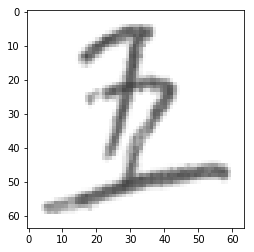

In [6]:
# Example of a picture
index = 300
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

To get started, let's examine the shapes of the data. 

In [8]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.

Y_train = convert_to_one_hot(Y_train_orig, 10)
Y_test = convert_to_one_hot(Y_test_orig, 10)
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 2389
number of test examples = 595
X_train shape: (2389, 64, 64, 3)
Y_train shape: (2389, 10)
X_test shape: (595, 64, 64, 3)
Y_test shape: (595, 10)


### 1.1 - Create placeholders


In [13]:
# GRADED FUNCTION: create_placeholders

def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder(tf.float32, shape=[None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, shape=[None, n_y])
    
    return X, Y

In [14]:
X, Y = create_placeholders(64, 64, 3, 10)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 10), dtype=float32)


# **Expected Output**

<table> 
<tr>
<td>
    X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)

</td>
</tr>
<tr>
<td>
    Y = Tensor("Placeholder_1:0", shape=(?, 10), dtype=float32)

</td>
</tr>
</table>

### 1.2 - Initialize parameters


In [25]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    W1 = tf.get_variable("W1",  [4, 4, 3, 8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2",  [2, 2, 8, 16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W3 = tf.get_variable("W3",  [64,10], initializer=tf.contrib.layers.xavier_initializer(seed=0))

    parameters = {"W1": W1,
                  "W2": W2,
                  "W3": W3}
    
    return parameters

In [26]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))
    print("W3 = " + str(parameters["W3"].eval()[1,1]))

W1 = [ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]
W3 = 0.2011595


# **Expected Output**

<table> 
<tr>
<td>
        W1 = [ 0.00131723  0.14176141 -0.04434952  0.09197326  0.14984085 -0.03514394  -0.06847463  0.05245192]
</td>
</tr>
<tr>
<td>
        W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228 -0.22779644 -0.1601823  -0.16117483 -0.10286498]
</td>
</tr>
<tr>
<td>
        W3 = 0.2011595
</td>
<tr>
</table>

### 1.2 - Forward propagation

In TensorFlow, there are built-in functions that carry out the convolution steps for you.

- **tf.nn.conv2d(X,W1, strides = [1,s,s,1], padding = 'SAME'):** given an input $X$ and a group of filters $W1$, this function convolves $W1$'s filters on X. The third input ([1,f,f,1]) represents the strides for each dimension of the input (m, n_H_prev, n_W_prev, n_C_prev). You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)

- **tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME'):** given an input A, this function uses a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window. You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool)

- **tf.nn.relu(Z1):** computes the elementwise ReLU of Z1 (which can be any shape). You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/nn/relu)

- **tf.contrib.layers.flatten(P)**: given an input P, this function flattens each example into a 1D vector it while maintaining the batch-size. It returns a flattened tensor with shape [batch_size, k]. You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten)

- **tf.contrib.layers.fully_connected(F, num_outputs):** given a the flattened input F, it returns the output computed using a fully connected layer. You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/fully_connected)

In the last function above (`tf.contrib.layers.fully_connected`), the fully connected layer automatically initializes weights in the graph and keeps on training them as you train the model. Hence, you did not need to initialize those weights when initializing the parameters. 


In [27]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding="SAME")
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize=[1,8,8,1], strides=[1,8,8,1], padding="SAME")
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1], padding="SAME")
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1], strides=[1,4,4,1], padding="SAME")
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    print(P2.shape)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.matmul(P2, W3)
    #tf.contrib.layers.fully_connected(P2, 6, activation_fn=None, weights_initializer=tf.contrib.layers.xavier_initializer(seed=0))

    return Z3

In [28]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 10)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,10)})
    print("Z3 = " + str(a))

(?, 64)
Z3 = [[-3.6391184  -0.40035227  2.6781216  -1.1577144  -0.7321389  -2.0522003
   2.0173051  -3.4039552  -1.0324228  -2.2833965 ]
 [-3.3136013  -0.2373559   2.5692573  -0.79102373 -0.2462411  -1.6117849
   1.7850623  -3.2946322  -1.1045172  -2.3272257 ]]


# **Expected Output**
（?, 64)

<table> 
    <td> 
    Z3 =
    </td>
    <td>
    [[-3.6391184  -0.40035227  2.6781216  -1.1577144  -0.7321389  -2.0522003
   2.0173051  -3.4039552  -1.0324228  -2.2833965 ] <br>
 [-3.3136013  -0.2373559   2.5692573  -0.79102373 -0.2462411  -1.6117849
   1.7850623  -3.2946322  -1.1045172  -2.3272257 ]]
    </td>
</table>

### 1.3 - Compute cost


In [29]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y)
    cost = tf.reduce_mean(cost)
    
    return cost

In [30]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 10)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,3), Y: np.random.randn(4,10)})
    print("cost = " + str(a))

(?, 64)
cost = 5.14554


# **Expected Output**
(?, 64)

<table>
    <td> 
    cost =
    5.14554
    </td> 
</table>

## 1.4 Model 

Finally you will merge the helper functions you implemented above to build a model. You will train it on the SIGNS dataset. 

You have implemented `random_mini_batches()` in the Optimization programming assignment of course 2. Remember that this function returns a list of mini-batches. 

In [39]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 128, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    saver = tf.train.Saver()
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
            # save parameters
            if epoch == num_epochs-1:
                saver.save(sess,'params.ckpt')
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Run the following cell to train your model for 100 epochs. Check if your cost after epoch 0 and 5 matches our output. If not, stop the cell and go back to your code!

(?, 64)
Cost after epoch 0: 2.445850
Cost after epoch 5: 0.448471
Cost after epoch 10: 0.281600
Cost after epoch 15: 0.219327
Cost after epoch 20: 0.194916
Cost after epoch 25: 0.160277
Cost after epoch 30: 0.152643
Cost after epoch 35: 0.131281
Cost after epoch 40: 0.096282
Cost after epoch 45: 0.103699
Cost after epoch 50: 0.088431
Cost after epoch 55: 0.089614
Cost after epoch 60: 0.082545
Cost after epoch 65: 0.070712
Cost after epoch 70: 0.060833
Cost after epoch 75: 0.084810
Cost after epoch 80: 0.059587
Cost after epoch 85: 0.063460
Cost after epoch 90: 0.048453
Cost after epoch 95: 0.055371


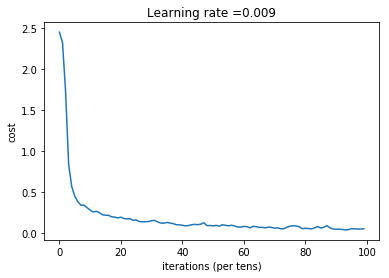

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.9794893
Test Accuracy: 0.9142857


In [40]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

# **Expected Output**

<table> 
<tr>
<td> 
    Cost after epoch 0 = 2.445850
</td> 
</tr>
<tr>
<td> 
    Cost after epoch 5 =0.448471
</td> 
</tr>
<tr>
<td> 
    Train Accuracy   =0.9794893
</td> 
</tr>
<tr>
<td> 
    Test Accuracy   =0.9142857
</td> 
</tr>
</table>

最后，使用训练得到的模型分别对训练集、测试集、以及自己上传一张照片进行预测。

1074
INFO:tensorflow:Restoring parameters from params.ckpt
(?, 64)
y = 5
[[-48.29488   -24.517239   -0.6631758  -2.965381   15.376597  -17.30787
    2.1256552 -32.44561    -7.268417   -9.7702055]]
[5]
predict y = [5]


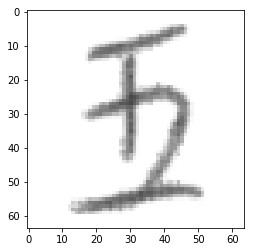

In [41]:
index = np.random.randint(0,2389) # choose from trainset randomly
print(index)
tf.reset_default_graph()

#predict
with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 10)
    parameters = initialize_parameters()
    
    # initial parameters
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # restore parameters
    variables = tf.global_variables()
    saver = tf.train.Saver()
    saver.restore(sess,'params.ckpt')
    
    # predict
    parametses = {variables[0],variables[1],variables[2]}
    predict_result = forward_propagation(X, parameters)
    
    #prepare data, use normalized data
    X_from_trainset = X_train[index].astype(np.float32)
    X_from_trainset = np.reshape(X_from_trainset,[1,64,64,3])
    Y_from_trainset = Y_train[index,:]
    Y_from_trainset = np.reshape(Y_from_trainset,[1,10])
    
    # display this picture
    plt.imshow(X_train_orig[index])
    print ("y = " + str(np.squeeze(Y_train_orig[:, index])))
    #

    # display predict result
    a = sess.run(predict_result, {X: X_from_trainset, Y: Y_from_trainset})
    print(a)
    predict_class = np.argmax(a, 1) + 1
    print(predict_class)
    print("predict y = " + str(predict_class))

168
INFO:tensorflow:Restoring parameters from params.ckpt
(?, 64)
y = 8
[[ -9.474406   -3.876262   -4.691547  -12.223262  -11.954524   -1.3432872
  -10.934512   20.351799  -12.143081   -5.1698093]]
[8]
predict y = [8]


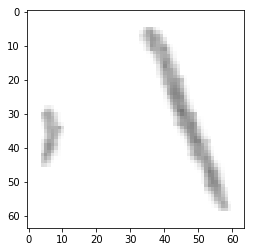

In [44]:
np.random.seed(2)
tf.reset_default_graph()
index = np.random.randint(0,595) # choose from testset randomly


print(index)

#predict
with tf.Session() as sess:
    
    X, Y = create_placeholders(64, 64, 3, 10)
    parameters = initialize_parameters()
    
    # initial parameters
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # restore parameters
    variables = tf.global_variables()
    saver = tf.train.Saver()
    saver.restore(sess,'params.ckpt')
    
    #predict
    parametses = {variables[0],variables[1],variables[2]}
    predict_result = forward_propagation(X, parameters)
    
    #prepare data, use nomalized data
    X_from_testset = X_test[index].astype(np.float32)
    X_from_testset = np.reshape(X_from_testset,[1,64,64,3])
    Y_from_testset = Y_test[index,:]
    Y_from_testset = np.reshape(Y_from_testset,[1,10])
    #X,Y = create_placeholders(64, 64, 3, 10)
    
    
    # display this picture
    plt.imshow(X_test_orig[index])
    print ("y = " + str(np.squeeze(Y_test_orig[:, index])))
    #

    #display predict result
    a = sess.run(predict_result, {X: X_from_testset, Y: Y_from_testset})
    print(a)
    predict_class = np.argmax(a, 1)+1
    print(predict_class)
    print("predict y = " + str(predict_class))

(64, 64, 3)
INFO:tensorflow:Restoring parameters from params.ckpt
(?, 64)
[[-91.351135  -17.580412    3.6903129  11.970592   17.934315   -8.288948
  -13.957195  -65.000275    6.710845  -58.550922 ]]
predict y = [5]


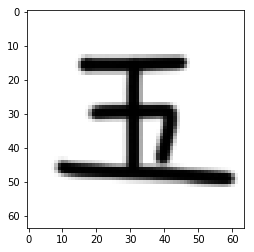

In [43]:
tf.reset_default_graph()

#load a picture taken by yourself
my_image = Image.open('test.png')
my_image = my_image.resize((64,64))
my_image = my_image.convert('RGB')
# display this picture
plt.imshow(my_image)

#prepare data
X_my_image = np.array(my_image)/255. # normalization
print(X_my_image.shape)
X_my_image = X_my_image.astype(np.float32)
X_my_image = np.reshape(X_my_image,[1,64,64,3])

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 10)
    parameters = initialize_parameters()
    
    #initialize parameters
    init = tf.global_variables_initializer()
    sess.run(init)
    
    #restore parameters
    variables = tf.global_variables()
    saver = tf.train.Saver()
    saver.restore(sess,'params.ckpt')
    
    #predict
    parametses = {variables[0],variables[1],variables[2]}
    predict_result = forward_propagation(X, parameters)
    
    #display predict result
    a = sess.run(predict_result, {X: X_my_image, Y: [[0,0,0,0,0,0,0,0,1,0]]})
    print(a)
    predict_class = np.argmax(a, 1) + 1
    print("predict y = " + str(predict_class))